In [56]:
#TODO: Can I put this in another file and import it somehow?
from pynq import DefaultIP
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import sem
from time import time, sleep

class ROControlDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)
        self.rm = self.register_map
    
    bindto = ['wiresboy.github.io:Brandon:axi_ro_control:1.1.1']
    
    def reset_ro(self):
        self.rm.Control[0] = 1
    
    def start_acquire(self):
        self.rm.Control[1] = 1
    
    @property
    def ro_quantity(self):# ROs enabled
        return self.rm.ro_quantity[31:16]
    @ro_quantity.setter
    def ro_quantity(self, num_ro_enabled):
        self.rm.RO_Quantity_Control[31:16] = num_ro_enabled
        
    
    @property
    def cycles(self): # cycles/integration
        return self.rm.RO_Quantity_Control[15:0]
    @cycles.setter
    def cycles(self, cycles_per_integration):
        self.rm.RO_Quantity_Control[15:0] = cycles_per_integration
    
    
    @property
    def power_virus(self): # of PV enabled
        #return self.rm.Power_Virus_Control
        return self.rm.Power_Virus_Level_01[15:0]
    @power_virus.setter
    def power_virus(self, num_power_virus):
        #self.rm.Power_Virus_Control = num_power_virus
        #All states of FSM get set to same value
        if isinstance(num_power_virus, list):
            self.power_virus_fsm = num_power_virus
        else:
            self.rm.Power_Virus_Level_01[15:0]  = num_power_virus
            self.rm.Power_Virus_Level_01[31:16] = num_power_virus
            self.rm.Power_Virus_Level_23[15:0]  = num_power_virus
            self.rm.Power_Virus_Level_23[31:16] = num_power_virus
    
    
    @property
    def power_virus_fsm(self): # of PV enabled
        rm = self.rm
        return [ (rm.Power_Virus_Level_01[15:0],  rm.Power_Virus_Cycles_01[15:0] ),
                 (rm.Power_Virus_Level_01[31:16], rm.Power_Virus_Cycles_01[31:16]),
                 (rm.Power_Virus_Level_23[15:0],  rm.Power_Virus_Cycles_23[15:0] ),
                 (rm.Power_Virus_Level_23[31:16], rm.Power_Virus_Cycles_23[31:16])]
    @power_virus_fsm.setter
    def power_virus_fsm(self, fsm_config):
        
        self.rm.Power_Virus_Level_01[15:0]  = fsm_config[0][0]
        self.rm.Power_Virus_Level_01[31:16] = fsm_config[1][0]
        self.rm.Power_Virus_Level_23[15:0]  = fsm_config[2][0]
        self.rm.Power_Virus_Level_23[31:16] = fsm_config[3][0]
        
        self.rm.Power_Virus_Cycles_01[15:0]  = fsm_config[0][1]
        self.rm.Power_Virus_Cycles_01[31:16] = fsm_config[1][1]
        self.rm.Power_Virus_Cycles_23[15:0]  = fsm_config[2][1]
        self.rm.Power_Virus_Cycles_23[31:16] = fsm_config[3][1]
     
    
    @property
    def mode(self): # mode: 1=continuous, 0=one shot
        return self.rm.Mode[0]
    @mode.setter
    def mode(self, mode):
        self.rm.Mode[0] = mode
        
    @property
    def status(self): #Status byte
        return self.rm.Control[7:0]  #Some bits of current index into bram
    
    @property
    def last_read_sum(self):
        return self.rm.Control[31:16] 
    


class XADCDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)
    
    bindto = ['xilinx.com:ip:xadc_wiz:3.3']

    @property
    def temperature_raw(self):
        return self.read(0x200) >> 4
    @property
    def temperature_c(self):
        return (self.temperature_raw * 503.975/4096)-273.15
    @property
    def temperature_f(self):
        return ((self.temperature_raw * 503.975/4096)-273.15)*9/5 +32
    
    @property
    def vccint_raw(self):
        return self.read(0x204) >> 4
    @property
    def vccint(self):
        return self.vccint_raw *3/4096
    
    @property
    def vccaux_raw(self):
        return self.read(0x208) >> 4
    @property
    def vccaux(self):
        return self.vccaux_raw *3/4096
    
    @property
    def vccbram_raw(self):
        return self.read(0x218) >> 4
    @property
    def vccbram(self):
        return self.vccbram_raw *3/4096
    
    @property
    def vccpint_raw(self):
        return self.read(0x234) >> 4
    @property
    def vccpint(self):
        return self.vccpint_raw *3/4096

def get_scaling(ro_cycles, ro_quantity):
    return  (ro_cycles-2) * ro_quantity / (ps.Clocks.fclk1_mhz * 1000000) 

def scale(value, scaling): #period = (ro_cycles-2) / clkfreq(hz)
    return value/scaling

def get_bram(ro_cycles, ro_quantity):
    scaling=get_scaling(ro_cycles, ro_quantity)
    return [scale(bram.read(offset=x),scaling) for x in range(0,bram.length, 4)]

#SW power virus
def swPV():
    zz = 1;
    for x in range(1,100000):
        zz = zz*x

def swSpeedTest():
    ro.power_virus = 0x0000

def swSpeedTestAlt():
    ro.power_virus = [(0xfc00, 0x4fff),
                      (0xfff0, 0x4fff),
                      (0xfc00, 0x4fff),
                      (0x0000, 0x2fff)]
    

    
#Generate X axis timestamps based on current ro, clk parameters
def timeList_us(l): 
    period = (ro.cycles) / (ps.Clocks.fclk1_mhz * 1000000)*1e6 #Scale to us
    print("period",period)
    return [x*period for x in range(l)]
    

#Return: list of values
def run_test(ro_quantity=1, ro_cycles = 2, power_virus = 0, swFunc = None):
    ro.ro_quantity = ro_quantity
    ro.cycles = ro_cycles
    ro.power_virus = power_virus
    ro.mode = 0 # One-shot
    ro.reset_ro()
    ro.start_acquire()
    while (ro.status < 0xff): #Wait for acquisition to finish. 
        if swFunc is not None:
            swFunc()
        #TODO: How to tell when long-duration tests are done? This doesn't show all the bits...
        pass
    return get_bram(ro_cycles, ro_quantity)

plt.rcParams['figure.figsize'] = [16, 10]

In [2]:
from pynq import Overlay
from pynq import ps
overlay = Overlay("z2_voltage_experiments_wrapper.bit")

ro = overlay.axi_ro_control_0
xadc=overlay.xadc_wiz_0
bram = overlay.axi_bram_ctrl_0.mmio
print(ps.Clocks.fclk0_mhz, ps.Clocks.fclk1_mhz)

#ps.Clocks.fclk0_mhz = 100 #Default 66MHz ??
ps.Clocks.fclk1_mhz = 50 #Default 125MHz ??

print(ps.Clocks.fclk0_mhz, ps.Clocks.fclk1_mhz)

66.666667 125.0
66.666667 50.0


In [ ]:
ROQ = 1024
ROC = 10

xlist = []
ylist = []
adclist = []
yerrlist = []
yminlist = []
ymaxlist = []
adcerrlist = []
#for pv in range(0, (2**16)-1, 63):#2047):
#for p in range(0, 16):#2047):
#    pv = 2**p
#tests = [2**n for n in range(0,16)] + [2**n + 2**(n-1) for n in range(1,16)]
tests = [2**n -1 for n in range(0,16)]
for pv in tests:
    sample = run_test(ro_quantity=ROQ, ro_cycles = ROC, power_virus = pv)
    adcsample = [1]
    for x in range(3):
        sample+= run_test(ro_quantity=ROQ, ro_cycles = ROC, power_virus = pv)
    #for x in range(1000): #Get 2000 ADC readings
    #    adcsample.append(xadc.vccpint)
    average = sum(sample)/len(sample)
    #stderr = sem(sample)
    xlist.append(pv)
    ylist.append(average)
    yminlist.append(min(sample))
    ymaxlist.append(max(sample))
    #yerrlist.append(stderr)
    
    adclist.append(sum(adcsample)/len(adcsample))
    #adcerrlist.append(sem(adcsample))

xlist = list(range(16))

In [ ]:
plt.rcParams['figure.figsize'] = [12, 10]
fig, (plt_ro, plt_adc) = plt.subplots(2, sharex=True)
fig.suptitle("RO Quantity="+str(ROQ)+", Cycles="+str(ROC))
fig.subplots_adjust(left=0.15)

plt_ro.errorbar(xlist, ylist, yerr=(yminlist, ymaxlist))
plt_ro.scatter(xlist, ylist, s=2.5, linestyle='None')
plt_ro.set(ylabel="RO Count")
plt_ro.set_title("RO sum vs #PV sets enabled (RO)")
#plt_ro.set(xlabel="Number of Power Virus")

#plt_adc.errorbar(xlist, adclist, yerr=adcerrlist)
plt_adc.scatter(xlist, adclist, s=1, linestyle='None')
plt_adc.set(xlabel="1000 * Number of Power Virus")
plt_adc.set(ylabel="ADC: VCCINT voltage")
plt_adc.set_title("Measured ADC vs #PV (RO)")

mhz = ps.Clocks.fclk1_mhz

fig.savefig("png/ROQuantity"+str(ROQ)+" Cycles"+str(ROC)+"_"+str(int(mhz))+"MHz_sameSetsPV_minmaxRO_"+str(int(time())%100000)+".png", dpi=150)

In [ ]:
yerrlist

In [ ]:
#power vs ADC

fig, (plt_adc) = plt.subplots(1, sharex=True)
fig.suptitle("RO Quantity="+str(ROQ)+", Cycles="+str(ROC))
fig.subplots_adjust(left=0.15)

plt_adc.scatter(ylist, adclist, s=1)
plt_adc.set(xlabel="RO Count")
plt_adc.set(ylabel="ADC: VCCINT voltage")
plt_adc.set_title("RO Count vs Measured ADC")

fig.savefig("png/ROCount vs ADC  -  ROQuantity"+str(ROQ)+" Cycles"+str(ROC)+"_"+str(int(time())%100000)+".png", dpi=300)

#fig.savefig("png/ROQuantity"+str(ROQ)+" Cycles"+str(ROC)+"_noerr_"+str(int(time())%100000)+".png", dpi=200)

In [ ]:
#ROQ tester
pv = 0xffff
ROC = 3

xlist = []
ylist = []
adclist = []
yerrlist = []
yminlist = []
ymaxlist = []
adcerrlist = []
#for pv in range(0, (2**16)-1, 63):#2047):
#for p in range(0, 16):#2047):
#    pv = 2**p
#tests = [2**n for n in range(0,16)] + [2**n + 2**(n-1) for n in range(1,16)]
tests = [2**n -1 for n in range(0,16)]
for ROQ in range(1024):
    sample = run_test(ro_quantity=ROQ, ro_cycles = ROC, power_virus = pv)
    #adcsample = []
    for x in range(1):
        sample+= run_test(ro_quantity=ROQ, ro_cycles = ROC, power_virus = pv)
    #for x in range(4000): #Get 2000 ADC readings
    #    adcsample.append(xadc.vccpint)
    average = sum(sample)/len(sample)
    #stderr = sem(sample)
    xlist.append(ROQ)
    ylist.append(average)
    yminlist.append(min(sample))
    ymaxlist.append(max(sample))
    #yerrlist.append(stderr)
    
    #adclist.append(sum(adcsample)/len(adcsample))
    #adcerrlist.append(sem(adcsample))


In [ ]:
#power vs ROQ

fig, (plt_adc) = plt.subplots(1, sharex=True)
fig.suptitle("Count vs Quantity, PV=0xff, Cycles="+str(ROC))
fig.subplots_adjust(left=0.15)

plt_adc.scatter(xlist, ylist, s=2)
plt_adc.set(xlabel="ROQ")
plt_adc.set(ylabel="RO Count")
plt_adc.set_title("RO Count vs Quantity")

fig.savefig("png/ROCount vs Quantity PV0xff Cycles"+str(ROC)+"_"+str(int(time())%100000)+".png", dpi=150)

#fig.savefig("png/ROQuantity"+str(ROQ)+" Cycles"+str(ROC)+"_noerr_"+str(int(time())%100000)+".png", dpi=200)

In [ ]:
ROQ = 4
ROC = 5

xlist = []
ylist = []
adclist = []
yerrlist = []
yminlist = []
ymaxlist = []
adcerrlist = []
#for pv in range(0, (2**16)-1, 63):#2047):
#for p in range(0, 16):#2047):
#    pv = 2**p
#tests = [2**n for n in range(0,16)] + [2**n + 2**(n-1) for n in range(1,16)]
tests = [2**n -1 for n in range(0,16)]
for pv in tests:
    sample = run_test(ro_quantity=ROQ, ro_cycles = ROC, power_virus = pv)
    adcsample = []
    for x in range(4):
        sample+= run_test(ro_quantity=ROQ, ro_cycles = ROC, power_virus = pv)
    for x in range(4000): #Get 2000 ADC readings
        adcsample.append(xadc.vccpint)
    average = sum(sample)/len(sample)
    #stderr = sem(sample)
    xlist.append(pv)
    ylist.append(average)
    yminlist.append(min(sample))
    ymaxlist.append(max(sample))
    #yerrlist.append(stderr)
    
    adclist.append(sum(adcsample)/len(adcsample))
    #adcerrlist.append(sem(adcsample))

xlist = list(range(16))

In [ ]:
for cyc in [1,2,3,10,100,200,500]:
    print("\n  ",cyc)
    ro.ro_quantity = 4 # ROs enabled
    ro.cycles = cyc # # cycles/integration
    ro.power_virus = 0x11
    ro.mode = 1 #Continuous
    ro.reset_ro()
    ro.start_acquire()
    from time import sleep
    for x in range(4):
        print(ro.status, "\t", ro.last_read_sum)

1319869565.2173913
1496440005.7326934
1877000000.0
period 0.5


0

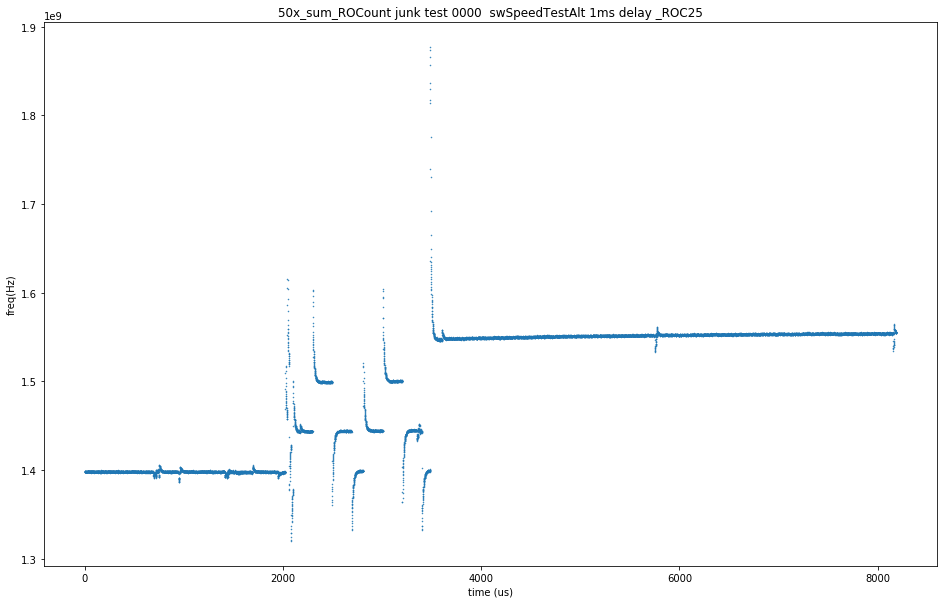

In [64]:
PVoscillate0 = [(0x0000, 2000),
               (0x0000, 2000),
               (0x0000, 2000),
               (0x0000, 2000)]

PVoscillateF = [(0xffff, 2000),
               (0xffff, 2000),
               (0xffff, 2000),
               (0xffff, 2000)]

PVoscillateAlt = [(0xfc00, 0x4fff),
                  (0xfff0, 0x4fff),
                  (0xfc00, 0x4fff),
                  (0x0000, 0x2fff)]

#name = "0000 always"
#name = "ffff always"
#name = "fc00_fff0_fc00_0000 at llls"
name = "junk test 0000  swSpeedTestAlt 1ms delay"

def swSpeedTestDelay():
    sleep(0.042)
    ro.power_virus = [(0xfc00, 0x4fff),
                      (0xfff0, 0x4fff),
                      (0xfc00, 0x4fff),
                      (0x0000, 0x2fff)]
    sleep(0.005)
    ro.power_virus = [(0xffff, 2000),
                      (0xffff, 2000),
                      (0xffff, 2000),
                      (0xffff, 2000)]

ro_quantity = 50
ro_cycles = 25
b=run_test(ro_quantity=ro_quantity, ro_cycles = ro_cycles, power_virus = PVoscillate0, swFunc = swSpeedTestDelay)#swSpeedTestAlt_20ms)

b=b[1:-1]

print(min(b))
print(sum(b)/len(b))
print(max(b))

plt.plot(timeList_us(len(b)), b, linestyle="none", marker=".", markersize=1)
plt.xlabel("time (us)")
plt.ylabel("freq(Hz)")
plt.title(str(ro_quantity)+"x_sum_ROCount "+name+" _ROC"+str(ro_cycles))
plt.savefig("png/"+str(ro_quantity)+"x_sum_ROCount realfreq "+name+" _ROC"+str(ro_cycles)+" "+str(int(time())%100000)+".png", dpi=150)
0

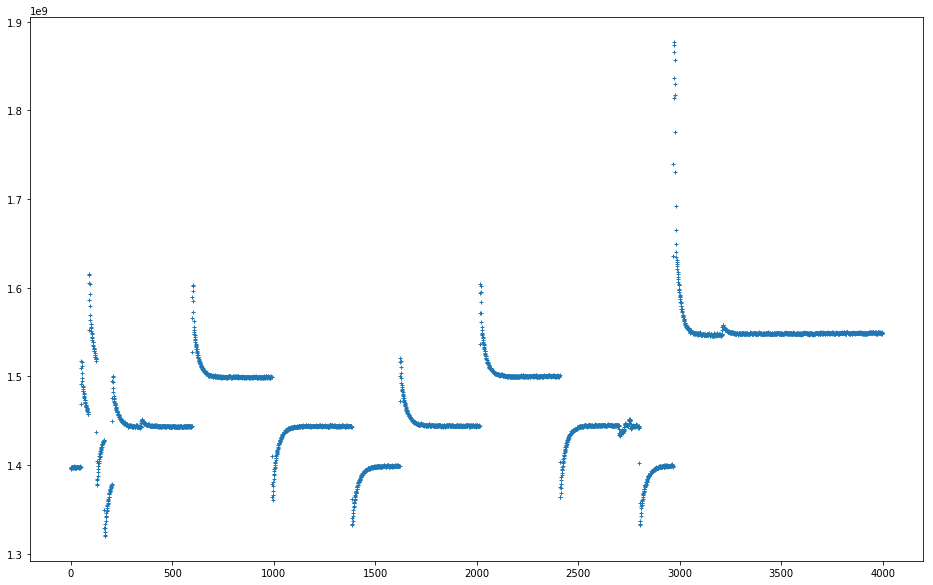

In [65]:
plt.rcParams['figure.figsize'] = [16, 10]
plt.plot(b[4000:8000], linestyle="none", marker="+", markersize=4)

30